# 不等流計算3:一般断面の不等流計算2-分割断面法（平均流速公式レベル2）

## 課題
分割断面法のクラスを以下のように定義する。

※前回は追加距離をLと定義しましたがdistanceに変更しました。

In [1]:
import numpy as np

class subsection(object):
    def __init__(self, x, y, n):
        self.x = x
        self.y = y
        self.n = n

    def H2ABSKn(self, H): #変更:引数は水位のみ
        A, B, S, SN = float(0), float(0), float(0), float(0)
        x = self.x #変更:メンバ変数を参照
        y = self.y #変更:メンバ変数を参照
        n = self.n #変更:メンバ変数を参照
        
        for i in range(1, len(x)):
            dx = x[i] - x[i-1]    
            dy = y[i] - y[i-1]    
            hb, hf = H - y[i-1], H - y[i]
            
            if hb <= float(0) :
                if hf > float(0) :
                    dx_dh = dx / (hf - hb)
                    B += hf * dx_dh
                    A += 0.5 * hf * hf * dx_dh
                    Sp = hf * np.sqrt( dx_dh * dx_dh + 1.0)
                    S +=  Sp
                    SN += Sp * n[i-1]**1.5
            elif hf <= float(0) :
                if hb > float(0) :
                    dx_dh = dx / (hf - hb)
                    B -= hb * dx_dh
                    A -= 0.5 * hb * hb * dx_dh
                    Sp = hb * np.sqrt(dx_dh * dx_dh + 1.0)
                    S += Sp
                    SN += Sp * n[i-1]**1.5
            else :
                B += dx
                A += 0.5 * dx * (hf + hb)
                Sp = np.sqrt(dx**2 + dy**2)
                S += Sp
                SN += Sp * n[i-1]**1.5
                
        if S <= float(0):
            nd = float(0)
            K = float(0)
        else:
            nd = (SN/S)**(2.0/3.0)
            K = A**(5.0/3.0)/nd/S**(2.0/3.0)
            
        return A, B, S, K, nd
    
    
class section(object):
    def __init__(self, X, Y, N, distance=np.nan):
        self._subsections = [subsection(x,y,n) for x,y,n in zip(X,Y,N)]
        self.distance = distance
        
    def H2ABSKnSub(self, H):
        num = len(self._subsections)
        A = np.zeros(num)
        B = np.zeros(num)
        S = np.zeros(num)
        K = np.zeros(num)
        n = np.zeros(num)
            
        for nump in range(num) : 
            A[nump], B[nump], S[nump], K[nump], n[nump] = self._subsections[nump].H2ABSKn(H)
            
        return A, B, S, K, n
    
#     def H2ABSK(self, H):
#         A, B, S, K, n = self.H2ABSKnSub(H)
#         return np.sum(A), np.sum(B), np.sum(S), np.sum(K)
    
    def H2ABSKRc(self, H):
        A, B, S, K, n = self.H2ABSKnSub(H)
        
        RA = float(0)
        for i in range(len(A)):
            if A[i] > 0 : RA += A[i]*(A[i]/S[i])**(2/3)
        Rc = (RA/A.sum())**1.5
        
        return A.sum(), B.sum(), S.sum(), K.sum(), Rc
    
    def zbmin(self):
        return np.array([s.y.min() for s in self._subsections]).min()
    
    
    def HQ2IeAlphaBetaVsub(self, H, Q):
        zero = float(0)
        As, Bs, Ss, Ks, ns = self.H2ABSKnSub(H)
        Vsub = np.zeros_like(As)
        
        sqrtIe = Q/Ks.sum()
        
        for i in range(len(As)):
            if As[i]>0: Vsub[i] = 1.0/ns[i]*(As[i]/Ss[i])**(2.0/3.0) * sqrtIe
        
        A = As.sum()
        V = Q/A
        Alpha = np.sum(As*Vsub**3)/V**3/A
        Beta  = np.sum(As*Vsub**2)/V**2/A
        
        return sqrtIe**2, Alpha, Beta, Vsub
    
    
    def H0(self, Q, ib, dh = float(0.1)):
        H = self.zbmin() + float(0.01)
        arr = self.HQ2IeAlphaBetaVsub(H, Q)
        ie = arr[0]
        
        while np.abs(ib - ie)/ie > 0.00001:
            if ib < ie:
                H += dh
            else :
                dh *= float(0.5)
                H -= dh
                
            arr = self.HQ2IeAlphaBetaVsub(H, Q)
            ie = arr[0]
        
        return H
    
    def Hc(self, Q, dh = float(0.1)):
        # 初期値は最深河床高+1cmとする。
        H = self.zbmin() + float(0.01)
        
        A,_,_,_,Rc = self.H2ABSKRc(H)
        Ie, Alpha, Beta, Vsub  = self.HQ2IeAlphaBetaVsub(H, Q)
        fr = Q/A/np.sqrt(float(9.8)*Rc)
        
        while np.abs(-float(1.0) + fr)/fr > 0.0001:
            if fr > float(1.0):
                H += dh
            else :
                dh *= float(0.5)
                H -= dh
                
            A,_,_,_,Rc = self.H2ABSKRc(H)
            Ie, Alpha, Beta, Vsub  = self.HQ2IeAlphaBetaVsub(H, Q)
            fr = Q/A/np.sqrt(float(9.8)*Rc)
        
        return H    
        

In [2]:
# 断面のデータ

x=np.array([0, 5,93,100,200,206,294,300])
y=np.array([6, 3.5, 3.5,  0,  0,  3,  3,  6])
n=np.array([0.041, 0.041,0.030,0.030,0.030,0.040,0.040])

X = [x[0:3], x[2:6], x[5:]]
Y = [y[0:3], y[2:6], y[5:]]
N = [n[0:2], n[2:5], n[5:]]

s = section(X,Y,N,0)
A,B,S,K, Rc = s.H2ABSKRc(5.0)
print('河積：{}\n水面幅：{}\n潤辺：{}\n通水能：{}\n井田の合成径深：{}'.format(A, B, S, K, Rc))

Ie, Alpha, Beta, Vsub = s.HQ2IeAlphaBetaVsub(1.0, 1500)
print('エネルギー補正係数：{}\n運動量補正係数：{}'.format(Alpha, Beta))

H0 =s.H0(1500,1/1500)
Hc = s.Hc(1500)

print('等流時水位：{}\n限界流時水位：{}'.format(H0, Hc))

河積：858.0
水面幅：296.0
潤辺：298.3606797749979
通水能：62445.88519359645
井田の合成径深：3.532459992338131
エネルギー補正係数：0.9999999999999986
運動量補正係数：0.999999999999999
等流時水位：4.843447265624999
限界流時水位：2.799453125000001


### 課題1

 1. 新たに定義したクラスsectionに運動量補正係数、エネルギー補正係数、井田の合成径深を計算するメソッドを追加せよ。
 2. 新たに定義したクラスsectionに等流時水位、限界流時水位を計算するメソッドを追加せよ。

上を参照

### 課題2

課題1で作成したクラスを用いて不等流計算モデルを実装し、縦断水位計算せよ。計算条件は以下のとおりとする。

 - 流量：$1500\rm{m^3/s}$
 - 下流端水位：等流水深（等流時水位）
 
断面データは前回課題と同様に以下のように定義する。

In [3]:
x=np.array([0, 5,93,100,200,206,294,300])
y=np.array([6, 3.5, 3.5,  0,  0,  3,  3,  6])
n=np.array([0.041, 0.041,0.030,0.030,0.030,0.040,0.040])

dx = 200
Ls = np.arange(0,15001,dx) 

sections = []
sect = {'x':x, 'y':y, 'n':n, 'L':Ls[0]}
sections.append(sect)

yold = y.copy()
ibs = []
ibs.append(1/2000)
for L in Ls[1:]:
    if L < 5000:
        ib = 1/2000
    elif L < 10000:
        ib = 1/1000
    else:
        ib = 1/500
        
    ynew = yold + dx*ib
    sect = {'x':x, 'y':ynew, 'n':n, 'L':L}
    sections.append(sect)
    yold = ynew.copy()
    ibs.append(ib)

In [4]:
csections = []

for s in sections:
    x, y, z, l = s['x'],s['y'],s['n'],s['L']
    X = [x[0:3], x[2:6], x[5:]]
    Y = [y[0:3], y[2:6], y[5:]]
    N = [n[0:2], n[2:5], n[5:]]
    csections.append( section(X,Y,N,l) )

In [5]:
def nonuniform(csections, Q, HDB):
    g = float(9.8)
    dhini = float(0.5)
    H = np.empty(len(csections))
    
    # 下流端水位
    # 添字dがi-1、添字pがiの値
    s = csections[0]
    Qd = Q
    Hd = HDB
    H[0] = Hd
    Ad,_,_,_,_ = s.H2ABSKRc(Hd)
    ied, _, Betad, _= s.HQ2IeAlphaBetaVsub(Hd, Qd)
    
    for i in range(1, len(csections)):
        # 収束計算の初期値は限界流時水位+1mm
        sp, sd = csections[i], csections[i-1]
        Qp = Q
        Hp = sp.Hc(Qp)
        Ap,_,_,_,_ = sp.H2ABSKRc(Hp)
        iep, _, Betap, _= sp.HQ2IeAlphaBetaVsub(Hp, Qp)
        dx = sp.distance - sd.distance
            
        E1 = Betap*0.5/g*Qp**2.0/Ap**2.0 + Hp
        E2 = Betad*0.5/g*Qd**2.0/Ad**2.0 + Hd + 0.5*dx*(ied + iep)
        
        Hp = Hp + float(0.001)
        dh = dhini
        for n in range(1000):
            Ap,_,_,_,_ = sp.H2ABSKRc(Hp)
            iep, _, Betap, _= sp.HQ2IeAlphaBetaVsub(Hp, Qp)
        
            E1 = Betap*0.5/g*Qp**2.0/Ap**2.0 + Hp
            E2 = Betad*0.5/g*Qd**2.0/Ad**2.0 + Hd + 0.5*dx*(ied + iep)
            
            if np.abs(E1 - E2) < 0.00001 : 
                break
            elif E1 > E2 :
                dh *= float(0.5)
                Hp -= dh
            else:
                Hp += dh
                
        H[i] = Hp
        Qd, Hd, ied, Ad, Betad = Qp, Hp, iep, Ap, Betap
        
    return H

In [6]:
Q = float(1500)
ib = float(1/2000)
# 下流端水位
s = csections[0]
Hd = s.H0(Q, ib)
H = nonuniform(csections, Q, Hd)

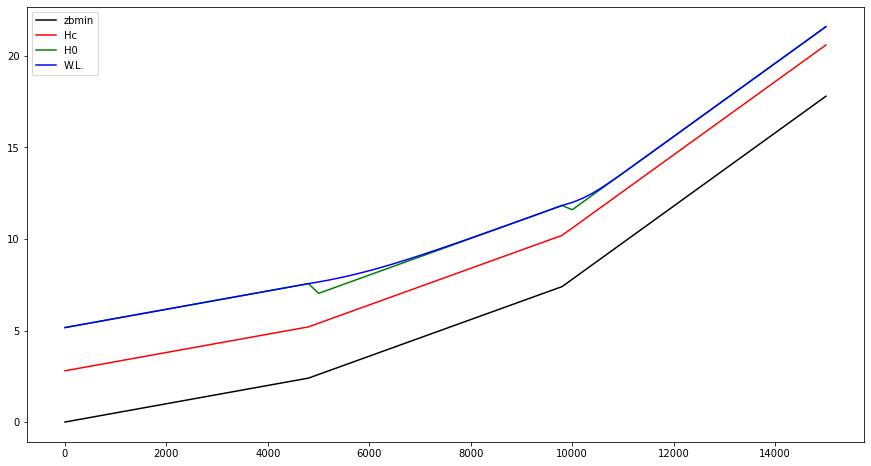

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))

L = [s.distance for s in csections]
zb = [s.zbmin() for s in csections]
gHc = [s.Hc(Q) for s in csections]
gH0 = [s.H0(Q,ibb) for s,ibb in zip(csections,ibs)]

plt.plot(L,zb,label='zbmin', color='k')
plt.plot(L,gHc,label='Hc', color='r')
plt.plot(L,gH0,label='H0', color='g')
plt.plot(L,H,label='W.L.', color='b')
plt.legend()
plt.show()

### 課題3

三重対角行列の数値解法であるTDMA法（トーマス法）について調べて、式を導出し、ソースコードを作成せよ。

wikipediaを読んでね。https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm

 - TDMA法は流体数値解析では必須の方法（オリエンテーションで話した）
 - ガウスの消去法は分割数Nの3乗の計算量であるが、TDMAでNの数倍程度の計算量ですむ。
 - 大規模演算に使用することを意識するとメモリ節約版も知っておくと良い。(引数をそのまま使うため、値が変わってしまう。)
 - メモリ節約を考えると入力もa,b,c,dの形式とするほうが良い。

In [8]:
import numpy as np

In [9]:
def TDMA(a,b,c,d):
    x, P, Q = np.empty_like(a), np.empty_like(a), np.empty_like(a)
    n = len(x)
    
    P[0], Q[0] = -c[0]/b[0], d[0]/b[0]
    for i in range(1, n):
        P[i] = -  c[i]                /(a[i]*P[i-1] + b[i])
        Q[i] =  (-a[i]*Q[i-1] + d[i])/(a[i]*P[i-1] + b[i])
        
    x[-1] = Q[-1]
    for i in range(n-2, -1, -1):
        x[i] = P[i]*x[i+1] + Q[i]
        
    return x

In [10]:
# https://nekodamashi-math.blog.ss-blog.jp/2017-12-03-2
def lmTDMA(a,b,c,d):
    n = len(a)
    #! 前進消去
    for i in range(1, n):
        ratio=a[i]/b[i-1]
        b[i]=b[i] - ratio*c[i-1]
        d[i]=d[i] - ratio*d[i-1]

    #! 後退代入
    d[-1]=d[-1]/b[-1]
    for i in range(n-2, -1, -1):
        d[i]=(d[i]-c[i]*d[i+1])/b[i]

    return d

$$
\begin{pmatrix}
 b_1 & c_1 & 0 & 0 \\
 a_2 & b_2 & c_2 & 0\\
 0 & a_3 & b_3 & c_3\\
 0 & 0 & a_4 & b_4
\end{pmatrix}
\begin{pmatrix}
 x_1 \\ x_2\\ x_3 \\ x_4
\end{pmatrix}=
\begin{pmatrix}
 d_1 \\ d_2\\ d_3 \\ d_4
\end{pmatrix}
$$

$$
\left( \begin{array}{ccc} 2 & 1 & 0 & 0 \\ 1 & 2 & 1 & 0 \\ 0 & 1 & 2 & 1 \\ 0 & 0 & 1 & 2 \end{array} \right) \left( \begin{array}{c} x_1 \\ x_2 \\ x_3 \\ x_4 \end{array} \right) = \left( \begin{array}{c} 4 \\ 8 \\ 12 \\ 11 \end{array} \right)
$$

In [11]:
a = np.array([0.0, 1.0, 1.0, 1.0])
b = np.array([2.0, 2.0, 2.0, 2.0])
c = np.array([1.0, 1.0, 1.0, 0.0])
d = np.array([4.0, 8.0, 12.0, 11.0])

# X = TDMA(a, b, c, d)
X = lmTDMA(a, b, c, d)
print(X)

[1. 2. 3. 4.]


### 課題4：アンケート

 - クラスの構成について意見をお願いします。無ければ大丈夫です。
     - メンバ変数について
         - 例えば、A,Bなどはメンバ変数にしたほうが良いか？私はプリミティブ変数（H）をクラスの外で定義してそれ以外の定数をメンバ変数として、クラスのメンバ変数は最小限とする書き方が好きです。
     - 変数、関数のネーミング
         - javaみたいにわかりやすく長くする。 x ⇒ coordsX、distance⇒distanceFromDownBoundaryなど
         - 関数名はどうする？H2ABSK ⇒ calsectionProfileとか
     - private,publicの関数、変数の明確化、getter、setterの定義等
     
    ...etc
     